# Nonlinear counterfactual generation using CEBRA and Principal Curves

This notebook demonstrates the workflow for analyzing DDIM latent data of fluid flow at two Reynolds numbers (Re=20 and Re=120). Using advanced tools like [CEBRA](https://github.com/AdaptiveMotorControlLab/cebra) and Principal Curve fitting, we explore latent embeddings, visualize them, project them back to DDIM latent space using modified latents, and generate counterfactuals.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load DDIM latent data of fluid flow with Re=20 and Re=120 for 3000 time points
Z_data = np.load('Z_data_Re20_120_time_3000.npy') # Data in DDIM latent space
Y_data = np.load('raw_labels_Re20_120_time_3000.npy') # Corresponding labels (fluid time points)

In [2]:
# Reverse indices for Re=20 to ensure the data aligns symmetrically
flip_idx = np.array(range(6000))
flip_idx[:3000] = flip_idx[:3000][::-1]  # Reverse the first 3000 indices for Re=20
Z_data = Z_data[flip_idx]

# Define and fit a CEBRA model
Train the CEBRA model to project the DDIM latent space of dimension $4\times 32\times 32$ into a 2D embedding.

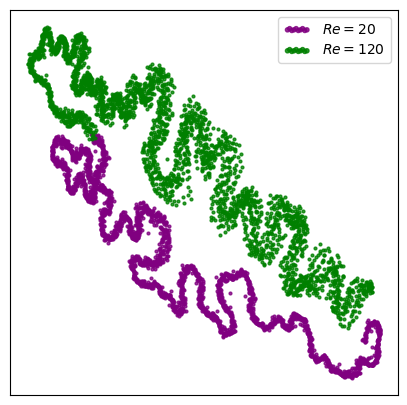

In [3]:
from cebra import CEBRA
max_iterations = 2000

cebra_model = CEBRA(model_architecture='offset1-model-mse',
                        batch_size=512,
                        learning_rate=1e-4,
                        output_dimension=2,
                        delta=0.001,
                        max_iterations=max_iterations,
                        distance='euclidean',
                        conditional='time_delta',  
                        device='cuda_if_available',
                        verbose=False,
                        time_offsets=10,
                   )

cebra_model.fit(Z_data)
Z_data_cebra = cebra_model.transform(Z_data)

# Visualize CEBRA embeddings for Re=20 and Re=120
N = 3000 # Number of time points for each Re

fig = plt.figure(figsize=(5,5))
plt.scatter(Z_data_cebra[:N,0], Z_data_cebra[:N,1], 
            c = 'purple', s = 4, alpha = 0.8, label = '$Re = 20 $')
plt.scatter(Z_data_cebra[N:,0], Z_data_cebra[N:,1], 
            c = 'green', s = 4, alpha = 0.8, label = '$Re =120$')

plt.legend(fontsize=10, scatterpoints=10, markerscale=1.5)
plt.xticks([])
plt.yticks([])
plt.show()

# Fit Principal Curves
Compute Elastic Principal Curves for Re=20 and Re=120 embeddings.

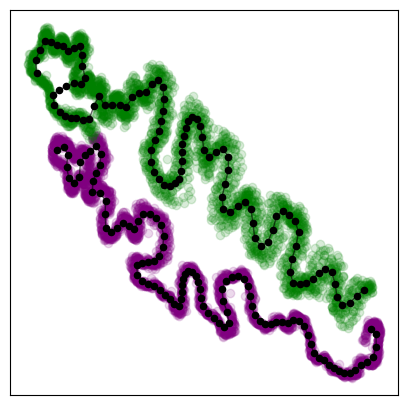

In [4]:
# Fit principal curve to CEBRA embedding of DDIM latents
import elpigraph
Z_pcurve1 = elpigraph.computeElasticPrincipalCurve(Z_data_cebra[:N,:],NumNodes=100,Lambda=0.005,Mu=0.005)[0]
Z_pcurve2 = elpigraph.computeElasticPrincipalCurve(Z_data_cebra[N:,:],NumNodes=100,Lambda=0.005,Mu=0.005)[0]

# plot graph (NodePositions and Edges) and data
f,axs=plt.subplots(1,1,figsize=(5,5))
elpigraph.plot.PlotPG(Z_data_cebra[:N,:],Z_pcurve1,Do_PCA=False,show_text=False,ax=axs,X_color='purple')
elpigraph.plot.PlotPG(Z_data_cebra[N:,:],Z_pcurve2,Do_PCA=False,show_text=False,ax=axs,X_color='green')
axs.set_xlabel('')
axs.set_ylabel('')
axs.set_xticks([])
axs.set_yticks([])
plt.show()

# Estimate principal curve $f(\alpha)$ using Node Positions and Interpolation

To estimate $f(\alpha)$, we use the node positions as reference points and apply interpolation techniques. This process involves the following steps:

1. **Node Position Collection**: Gather the coordinates of each node, representing points in space associated with specific values of  $\alpha$.

2. **Interpolation**: Use nearest-neighbor interpolation method to estimate $f(\alpha)$ at positions not directly covered by the nodes. This allows us to approximate the function's values across the space between nodes.

3. **Visualization**: Plot both the node positions and the interpolated estimates of $f(\alpha)$ to compare the original data points with the interpolated values.

This approach provides a smooth estimation of $f(\alpha)$ across the domain defined by the node positions.


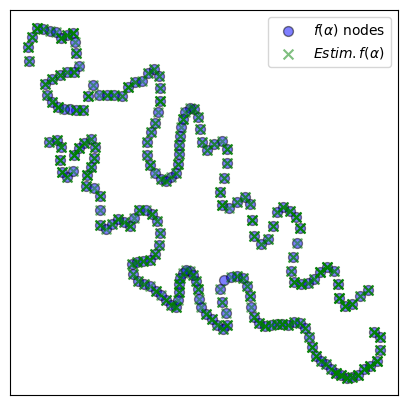

In [8]:
from scipy.interpolate import interp1d

node_positions_Re20 = Z_pcurve1['NodePositions']
node_positions_Re120 = Z_pcurve2['NodePositions']

node_positions = np.concatenate((node_positions_Re20, node_positions_Re120))

# Estimate principal curve
def estimate_f_alpha(node_positions, alpha_values):
    """
    Estimate f(alpha) using the node positions along the curve.

    Parameters:
    - node_positions: Array of shape (n_nodes, n_dimensions) representing node positions.
    - alpha_values: Array of alpha values in [0, 1] for which to estimate f(alpha).

    Returns:
    - f_alpha_estimates: Array of shape (len(alpha_values), n_dimensions) for the estimated positions along the curve.
    """
    # Step 1: Compute pairwise distances between consecutive nodes
    distances = np.linalg.norm(np.diff(node_positions, axis=0), axis=1)
    cumulative_distances = np.concatenate([[0], np.cumsum(distances)])

    # Normalize cumulative distances to range from 0 to 1
    normalized_distances = cumulative_distances / cumulative_distances[-1]

    # Step 2: Interpolate for each alpha
    f_alpha_estimates = []
    for dim in range(node_positions.shape[1]):
        # Create an interpolation function for the current dimension
        interpolation_function = interp1d(normalized_distances, node_positions[:, dim], kind='nearest') # replace by nearest
        # Interpolate for the given alpha values
        f_alpha_dim = interpolation_function(alpha_values)
        f_alpha_estimates.append(f_alpha_dim)

    # Combine interpolated dimensions
    f_alpha_estimates = np.stack(f_alpha_estimates, axis=-1)

    return np.array(f_alpha_estimates)

alpha_values = np.linspace(0, 1, 500)  # 500 alpha values evenly spaced between 0 and 1

# Output the estimated positions for each alpha
f_alpha_estimates = estimate_f_alpha(node_positions, alpha_values)

# Plot the estimated f(\alpha)
fig = plt.figure(figsize=(5,5))
plt.scatter(node_positions[:, 0], node_positions[:, 1], s=50, color='b', edgecolor='k', alpha=0.5, marker='o', label='$f(\\alpha)$ nodes')
plt.scatter(f_alpha_estimates[:, 0], f_alpha_estimates[:, 1], s=50, color='g', alpha=0.5, marker='x', label='$Estim. f(\\alpha)$')
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()


# Move along principal curve
Modify latent codes near the curve and find high-dimensional neighbors for projection back to original DDIM latent space.

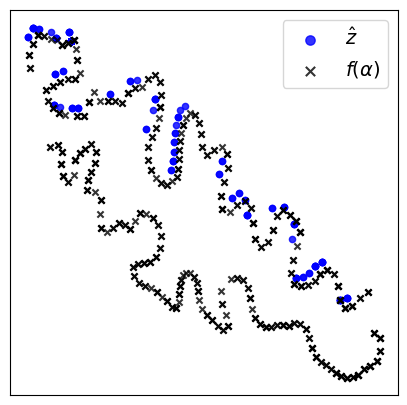

In [13]:
# Projecting a CEBRA latent code near to the curve f(\alpha) and moving along the curve
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Assuming `f_curve` is the estimated curve, and `z_t` is a single latent embedding in CEBRA.

def closest_point_on_curve(z_t, f_curve):
    distances = np.linalg.norm(f_curve - z_t, axis=1)
    t_index = np.argmin(distances)
    return t_index, f_curve[t_index]

def compute_residual(z_t, f_t):
    return z_t - f_t

def modify_latent_code(f_curve, t_index, alpha, residual):
    # Ensure that the new index is within bounds [0, len(f_curve) - 1]
    new_t_index = int(min(max(t_index + alpha, 0), len(f_curve) - 1))
    return f_curve[new_t_index] + residual

# Using nearest neighbors to project back to high-dimensional space
def find_high_dim_neighbors(z_1, embedded_space, high_dim_space, k=30):
    nbrs = NearestNeighbors(n_neighbors=k).fit(embedded_space)
    distances, indices = nbrs.kneighbors([z_1])  # Ensure z_1 is 2D for input
    weights = 1 / (distances + 1e-5)  # Small value to avoid division by zero
    weights /= weights.sum()  # Normalize weights
    high_dim_neighbors = high_dim_space[indices[0]]
    weighted_avg = np.average(high_dim_neighbors, axis=0, weights=weights[0])
    return weighted_avg, indices[0]

# Usage
indx = 5000  # Choose a single point index for z_t
z_t = Z_data_cebra[indx]  # Single point from the CEBRA data
t_index, f_t = closest_point_on_curve(z_t, f_alpha_estimates[250:])
residual = compute_residual(z_t, f_t)

alpha_values = list(range(-100,200))   # Range of alpha values for modifications
high_dim_projections = []
Z_1 = []
for alpha in alpha_values:
    z_1 = modify_latent_code(f_alpha_estimates[250:], t_index, alpha=alpha, residual=residual)
    Z_1.append(z_1)
    high_dim_projection, neighbors = find_high_dim_neighbors(z_1, Z_data_cebra[N:], Z_data[N:])
    high_dim_projections.append(high_dim_projection)

modified_latents = np.array(Z_1)

# Principal curve traversal
fig = plt.figure(figsize=(5,5))
plt.scatter(modified_latents[:, 0], modified_latents[:, 1], s=20, c='b', alpha=0.8, marker='o', label='$\hat{z}$')
plt.scatter(f_alpha_estimates[:, 0], f_alpha_estimates[:, 1], s=20, color='k', alpha=0.8, marker='x', label='$f(\\alpha)$')
plt.legend(fontsize=14, scatterpoints=1, markerscale=1.5)
plt.xticks([])
plt.yticks([])
plt.show()

# Decode Modified Latents to Image Space
Use the trained VAE, trained U-Net and DDIM sampling equations to decode the projected modified latents back into fluid flow counterfactual images.

In [10]:
# Import libraries
import torch
import torchvision
import numpy as np
import random
import copy
import gc
#import sys
import os
import PIL
from PIL import Image

from models import *
import matplotlib.pyplot as plt
from diffusers import LMSDiscreteScheduler, DDIMScheduler, AutoencoderKL
from utils import *
import timeit
from tqdm.auto import tqdm


# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
# To the GPU we go!
vae = vae.to(device)

# The noise scheduler
noise_scheduler = LMSDiscreteScheduler(
    beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000
)

niters = 40000
# Load pretrained model
Filename_LDM = 'cLDM_checkpoint_niters_{}.pth'.format(niters)
print("Loading pre-trained continuous conditional latent diffusion model >>>")
checkpoint = torch.load(Filename_LDM, map_location=device,weights_only=True)
netLDM = cont_cond_unet_diffusion_model().to(device)
netLDM = nn.DataParallel(netLDM)
#netLDM.load_state_dict(checkpoint['netLDM_state_dict'])    
# Adjust checkpoint keys if necessary
checkpoint_state_dict = checkpoint['netLDM_state_dict']
adjusted_state_dict = {}

for key, value in checkpoint_state_dict.items():
    # Replace naming inconsistencies
    new_key = key.replace("query", "to_q").replace("key", "to_k").replace("value", "to_v").replace("proj_attn", "to_out.0")
    adjusted_state_dict[new_key] = value

# Load the adjusted state dict
netLDM.load_state_dict(adjusted_state_dict, strict=True)

Loading pre-trained continuous conditional latent diffusion model >>>


<All keys matched successfully>

In [11]:
# Normalized labels for U-Net
labels_train = np.load('norm_labels_Re20_120_time_3000.npy')

# Sample function (regular DDIM) (invert noisy latents back to original latents)
@torch.no_grad()
def sample(start_step=0, start_latents=None, num_inference_steps=30, labels=labels_train, device=device):
  
    # Set num inference steps
    noise_scheduler.set_timesteps(num_inference_steps, device=device)
    latents_list = []
    # Create a random starting point if we don't have one already
    if start_latents is None:
        start_latents = torch.randn(1, 4, 32, 32, device=device)
        start_latents *= noise_scheduler.init_noise_sigma

    latents = start_latents.clone()
    timesteps_sample = noise_scheduler.timesteps.long()
    for i in tqdm(range(start_step, num_inference_steps-1)):
    
        #t = noise_scheduler.timesteps[i]
        t = timesteps_sample[i]

        # predict the noise residual
        noise_pred = netLDM.module(latents, t, labels)
        
        prev_t = t-1#max(1, t.item()-1) #max(1, t.item() - (1000//num_inference_steps)) # t-1
        alpha_t = noise_scheduler.alphas_cumprod[t]
        alpha_t_prev = noise_scheduler.alphas_cumprod[prev_t]
        beta_t = 1 - alpha_t
        pred_original_sample = (latents - beta_t ** 0.5 * noise_pred) / alpha_t ** 0.5
        pred_sample_direction = (1 - alpha_t_prev) ** 0.5 * noise_pred
        prev_sample = alpha_t_prev ** 0.5 * pred_original_sample + pred_sample_direction
        latents = prev_sample

        # Store
        latents_list.append(latents)
    return latents_list

In [16]:
# Sort the label indices
from scipy.spatial import distance
idx_test = list(range(0,3000,10))
Z_cebra_test = Z_data_cebra[N:]
distances = distance.cdist(modified_latents, Z_cebra_test[idx_test], 'euclidean')
sorted_indices = np.argmin(distances, axis=0)
sorted_modified_latents = modified_latents[sorted_indices]

high_dim_projections = np.array(high_dim_projections)[sorted_indices]
new_projections = high_dim_projections.reshape(len(alpha_values),4,32,32)

  0%|          | 0/999 [00:00<?, ?it/s]

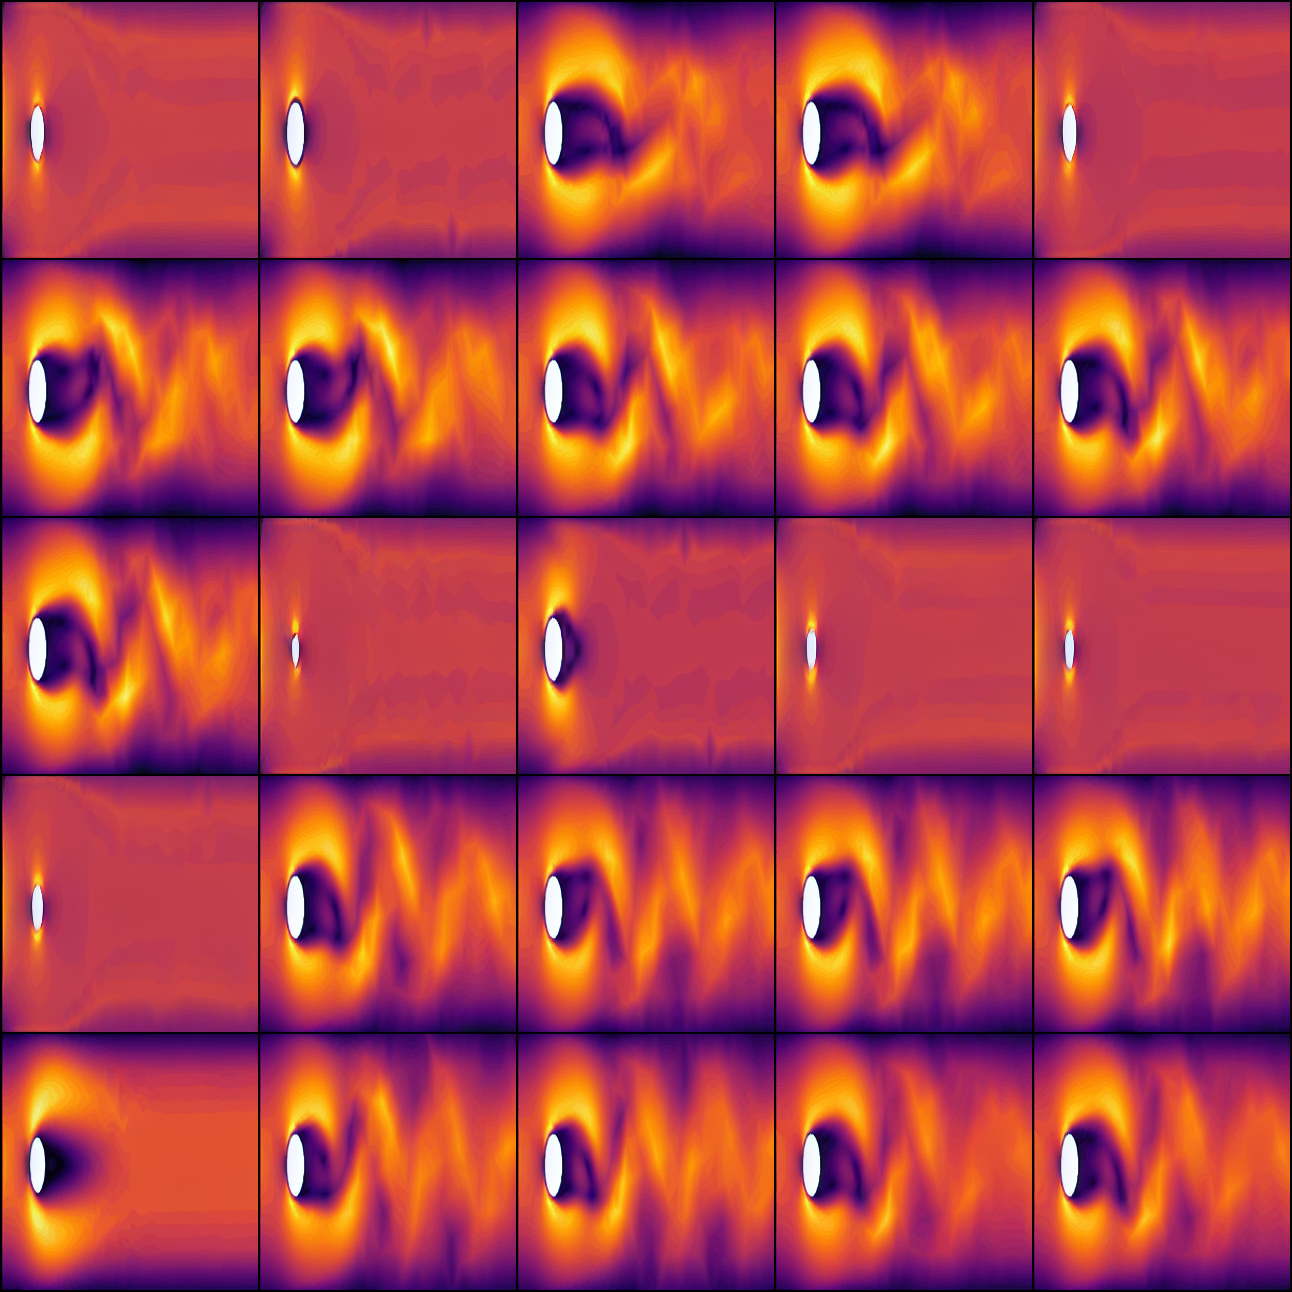

In [17]:
labels_train_test = labels_train[N:]
labels_test = labels_train_test[idx_test]
idx_y = list(range(100,len(alpha_values),8))

modified_ddim_latents = new_projections

test_latents = torch.tensor(modified_ddim_latents[idx_y]).type(torch.float) #Re=120
test_labels = torch.tensor(labels_test[idx_y]).type(torch.float).unsqueeze(-1)

ddim_sample = sample(start_latents=test_latents, num_inference_steps=1000, 
                       labels=test_labels, start_step=0, device=device)

ddim_sample = (1 / 0.18215) * ddim_sample[-1]
with torch.no_grad():
    ddim_sample = vae.decode(ddim_sample).sample 

# Visualize generated counterfactuals
def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x, nrow=5)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im
show_images(ddim_sample)